In [53]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import numpy as np

In [54]:
dados = pd.read_csv("../src/dados_completos.csv")

Inicialmente eu vou pegar os dados e fazer a média de cada mês por cidade, então teremos os dados na seguinte disposição:

\begin{array}{|l|c|c|c|c|c|}
\hline
\text{Cidade} & 01 & 02 & 03 & \cdots & 12 \\
\hline
\text{Abreu e Lima} & 7.61 & 10.58 & 9.12 & \cdots & 8.95 \\
\text{Afogados...} & 5.23 & 6.89 & 7.45 & \cdots & 4.12 \\
\hline
\end{array}

In [55]:
monthly_avg = dados.groupby(['Cidade', dados['Data'].str.split('-').str[1]])['Precipitacao_mm_mes'].mean().unstack()
monthly_avg.columns = [f'Precip_Media_Mes_{i+1:02d}' for i in range(12)]

Abaixo eu vou pegar as informações de Latitude, Logitude e Mesorregião de cada cidade e em seguinte vou agrupar, 
então os dados vão ficar com a seguinte diposição:
\begin{array}{|c|c|c|c|c|c|c|c|c|}
\hline
\text{Cidade} & \text{01} & \text{02} & \text{03} & \cdots & \text{12} & \text{Latitude} & \text{Longitude} & \text{Mesorregião} \\
\hline
\text{Abreu e Lima} & 7.61 & 10.58 & 9.12 & \cdots & 8.95 & -7.9116 & 34.90 & \text{Metropolitana do Recife} \\
\hline
\text{Afogados...} & 5.23 & 6.89 & 7.45 & \cdots & 4.12 & -7.75 & 37.64 & \text{Sertão Pernambucano} \\
\hline
\end{array}

In [56]:
cidades_info = dados.groupby('Cidade')[['Latitude', 'Longitude', 'Mesorregião']].first()
dados_agregados = monthly_avg.merge(cidades_info, left_index=True, right_index=True)

Eu pego as colunas de precipitação e coloco elas em uma lista e determino que essa lista vai ser nossa feature

In [57]:
features = [f'Precip_Media_Mes_{i+1:02d}' for i in range(12)]
X = dados_agregados[features]

Normalizo os dados

In [58]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Primeiro eu criei o modelo com o raio de busca de 1.2 e com o número minimo de pontos 3 para formar um clsuter. Execução do DBSCAN:
* Escolhe um ponto aleatório não visitado
* encontra todos os pontos dentro daquele raio
* se encontrar pelo menos 3 pontos forma um cluster se não encontrasr pontos sufientes marca com ruído
* repete até todos os pontos serem visitados

Deposi eu treio o modelo e dados gardos os resultados obtidos.

In [59]:
DBSCAN = DBSCAN(eps=1.2, min_samples=3)
labels = dbscan.fit_predict(X_scaled)
dados_agregados["Cluster"] = labels

* O primeiro gráfico mostra o padrão de precipição de cada cluster ao longos dos meses
* O Segundo gráfico mostra geográficamente os clusteres. Ele pega a latitude e a longitude de cada cidade e mostra a que cluster aquela cidade pertence
* O Terceiro gráfico mostra quantas cidades de cada mesorregião pertece a determinado cluster

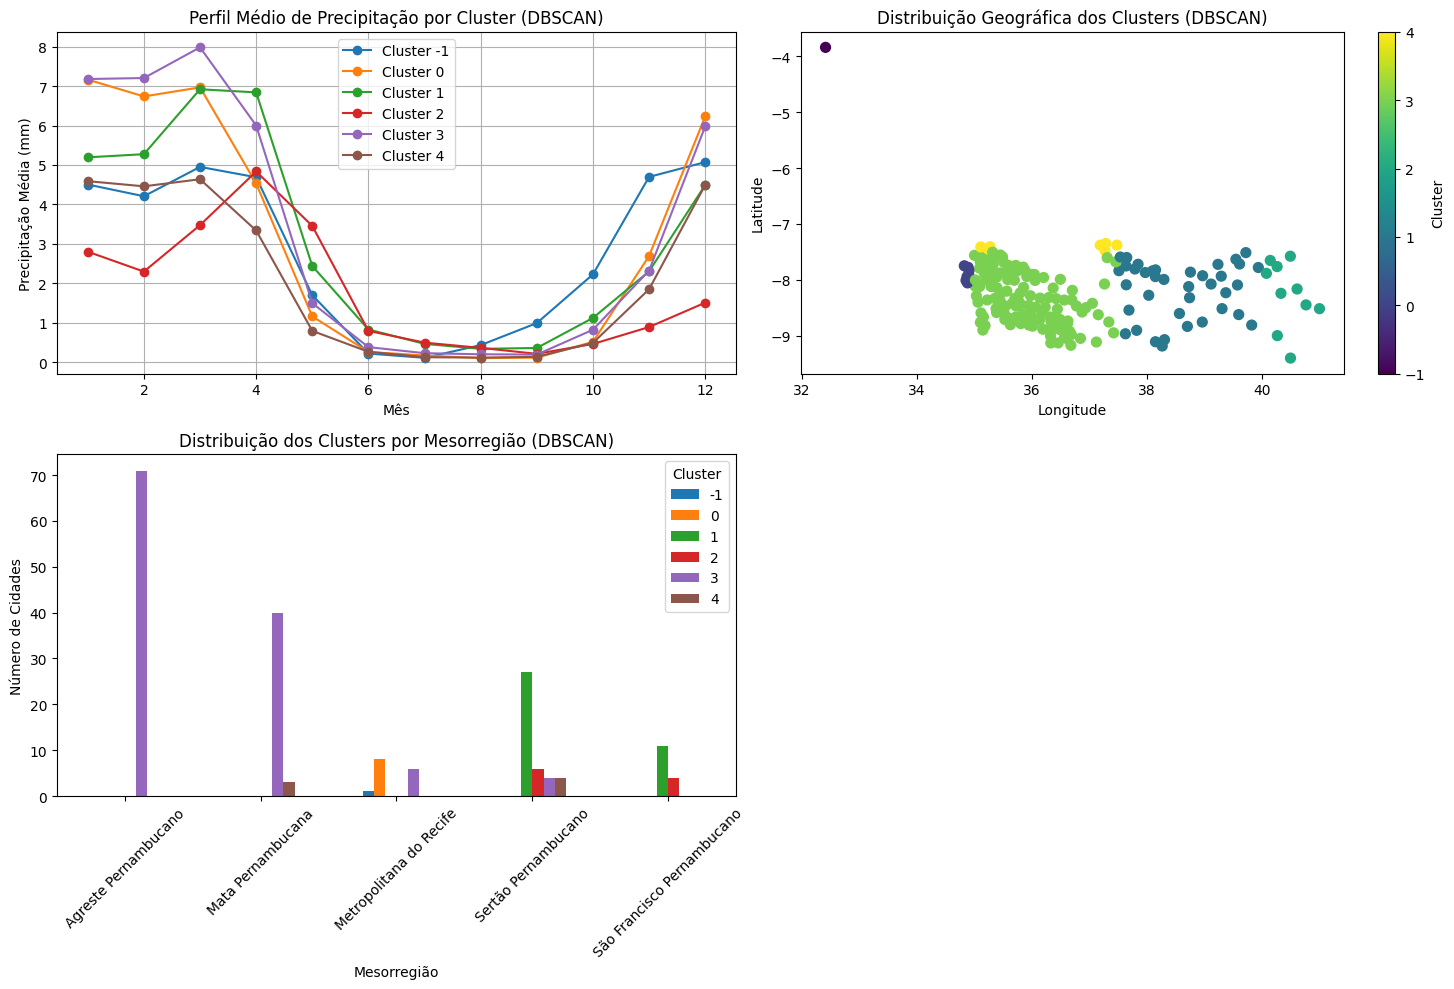

In [60]:
cluster_profiles = dados_agregados.groupby('Cluster')[features].mean()

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
# Plot 1: Perfis de precipitação por cluster
for cluster in sorted(dados_agregados['Cluster'].unique()):
    plt.plot(
        range(1, 13),
        cluster_profiles.loc[cluster],
        marker='o',
        label=f'Cluster {cluster}'
    )

plt.title('Perfil Médio de Precipitação por Cluster (DBSCAN)')
plt.xlabel('Mês')
plt.ylabel('Precipitação Média (mm)')
plt.legend()
plt.grid(True)

# Plot 2: Distribuição geográfica
plt.subplot(2, 2, 2)
scatter = plt.scatter(
    dados_agregados['Longitude'],
    dados_agregados['Latitude'],
    c=dados_agregados['Cluster'],
    cmap='viridis',
    s=50
)
plt.colorbar(scatter, label='Cluster')
plt.title('Distribuição Geográfica dos Clusters (DBSCAN)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Plot 3: Distribuição por mesorregião
plt.subplot(2, 2, 3)
cross_tab = pd.crosstab(
    dados_agregados['Mesorregião'],
    dados_agregados['Cluster']
)
cross_tab.plot(kind='bar', ax=plt.gca())
plt.title('Distribuição dos Clusters por Mesorregião (DBSCAN)')
plt.xlabel('Mesorregião')
plt.ylabel('Número de Cidades')
plt.xticks(rotation=45)
plt.legend(title='Cluster')

plt.tight_layout()
plt.show()

Vizualicação de cada cidade que pertece a cada cluster

In [61]:
# Adicionar rótulos ao dadosframe
X["Cluster"] = labels

print("\n=== CIDADES POR CLUSTER ===")
for cluster_id in sorted(X["Cluster"].unique()):
    print(f"\n🌀 Cluster {cluster_id}:")
    print(X[X["Cluster"] == cluster_id].index.tolist())


=== CIDADES POR CLUSTER ===

🌀 Cluster -1:
['Fernando de Noronha']

🌀 Cluster 0:
['Abreu e Lima', 'Camaragibe', 'Igarassu', 'Ilha de Itamaracá', 'Itapissuma', 'Olinda', 'Paulista', 'Recife']

🌀 Cluster 1:
['Afogados da Ingazeira', 'Belém do São Francisco', 'Betânia', 'Bodocó', 'Cabrobó', 'Calumbi', 'Carnaubeira da Penha', 'Carnaíba', 'Cedro', 'Custódia', 'Exu', 'Flores', 'Floresta', 'Granito', 'Ibimirim', 'Iguaracy', 'Inajá', 'Itacuruba', 'Jatobá', 'Manari', 'Mirandiba', 'Moreilândia', 'Orocó', 'Parnamirim', 'Petrolândia', 'Quixaba', 'Salgueiro', 'Santa Cruz da Baixa Verde', 'Santa Maria da Boa Vista', 'Serra Talhada', 'Serrita', 'Solidão', 'São José do Belmonte', 'Tabira', 'Tacaratu', 'Terra Nova', 'Triunfo', 'Verdejante']

🌀 Cluster 2:
['Afrânio', 'Araripina', 'Dormentes', 'Ipubi', 'Lagoa Grande', 'Ouricuri', 'Petrolina', 'Santa Cruz', 'Santa Filomena', 'Trindade']

🌀 Cluster 3:
['Agrestina', 'Alagoinha', 'Aliança', 'Altinho', 'Amaraji', 'Angelim', 'Araçoiaba', 'Arcoverde', 'Barra d

C:\Users\mclar\AppData\Local\Temp\ipykernel_2336\3594939032.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["Cluster"] = labels


Verifique as metricas desse meu treinamento.
* Silhouette Score: Quão bem cada ponto se encaixa no seu cluster vs nos outros clusters
* Calinski-Harabasz Index: Razão entre a dispersão ENTRE clusters vs DENTRO dos clusters
* Davies-Bouldin Index: Similaridade média entre cada cluster e seu cluster mais similar

In [62]:

print("=== AVALIAÇÃO DO DBSCAN ===")
# Só calculamos métricas se houver mais de 1 cluster e pelo menos 2 pontos por cluster
clusters_validos = len(set(labels)) - (1 if -1 in labels else 0)

if clusters_validos > 1:
    # Remover ruído para cálculo das métricas - é comum fazer isso
    mask = labels != -1  # Filtra pontos de ruído
    
    if sum(mask) > 1 and len(set(labels[mask])) > 1:
        silhouette_db = silhouette_score(X_scaled[mask], labels[mask])
        calinski_db = calinski_harabasz_score(X_scaled[mask], labels[mask])
        davies_db = davies_bouldin_score(X_scaled[mask], labels[mask])
    else:
        silhouette_db = calinski_db = davies_db = -1
        print("Não é possível calcular métricas - muito ruído ou poucos clusters válidos")
else:
    silhouette_db = calinski_db = davies_db = -1
    print("DBSCAN encontrou apenas 1 cluster ou apenas ruído")
    
if silhouette_db != -1:
    print(f"MÉTRICAS DE QUALIDADE (excluindo ruído):")
    print(f"   Silhouette Score: {silhouette_db}")
    print(f"   Calinski-Harabasz Index: {calinski_db}")
    print(f"   Davies-Bouldin Index: {davies_db}")



=== AVALIAÇÃO DO DBSCAN ===
MÉTRICAS DE QUALIDADE (excluindo ruído):
   Silhouette Score: 0.9999999974212063
   Calinski-Harabasz Index: 6.027585424044852e+31
   Davies-Bouldin Index: 1.6291425240599103e-08
